In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')


In [17]:

# Load the data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')


y = train['SalePrice']

key_features = [
    'OverallQual', 'TotalBsmtSF', 'GrLivArea', 'YearRemodAdd', 
    'TotRmsAbvGrd', 'FullBath', 'Fireplaces'  # Fireplaces is the correct column name
]

additional_features = [
    'YearBuilt', 'LotArea', 'GarageCars', 'GarageArea', 
    '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'KitchenQual', 
    'ExterQual', 'MSZoning', 'Neighborhood', 'BsmtQual'
]

ntrain = train.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train.drop('SalePrice', axis=1), test)).reset_index(drop=True)

def preprocess_data(df):
    if 'TotalBsmtSF' in df.columns and df['TotalBsmtSF'].isnull().sum() > 0:
        df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(0)
    categorical_features = df.select_dtypes(include=['object']).columns

    # Handle catgeorical feature
    for col in categorical_features:
        df[col] = df[col].fillna('None')
        lbl = LabelEncoder()
        df[col] = lbl.fit_transform(df[col].astype(str))
    
    # Handle numeric features
    numeric_features = df.select_dtypes(exclude=['object']).columns
    for col in numeric_features:
        df[col] = df[col].fillna(df[col].median())
    
    return df


In [18]:

def engineer_features(df):
    df['TotalSF'] = df['GrLivArea'] + df['TotalBsmtSF']
    if 'ExterQual' in df.columns and 'KitchenQual' in df.columns:
        # Convert quality features to numeric if they're not already
        qual_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
        if df['ExterQual'].dtype == 'object':
            df['ExterQual'] = df['ExterQual'].map(qual_map).fillna(0)
        if df['KitchenQual'].dtype == 'object':
            df['KitchenQual'] = df['KitchenQual'].map(qual_map).fillna(0)
        
        df['QualityScore'] = df['OverallQual'] * df['ExterQual'] * df['KitchenQual']
    
    # Age-related features
    df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
    df['IsRemodeled'] = (df['YearRemodAdd'] != df['YearBuilt']).astype(int)
    
    # Bathroom and room metrics
    df['TotalBath'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
    df['RoomRatio'] = df['TotRmsAbvGrd'] / df['GrLivArea']
    
    df['LivingSpace_x_Quality'] = df['GrLivArea'] * df['OverallQual']
    df['HasBasement'] = (df['TotalBsmtSF'] > 0).astype(int)
    df['HasFireplace'] = (df['Fireplaces'] > 0).astype(int)
    
    return df

# Apply preprocessing
all_data = preprocess_data(all_data)
all_data = engineer_features(all_data)

# Split back into train and test
train_processed = all_data[:ntrain]
test_processed = all_data[ntrain:]


selected_features = key_features + additional_features + [
    'TotalSF', 'QualityScore', 'HouseAge', 'RemodAge', 'IsRemodeled',
    'TotalBath', 'RoomRatio', 'LivingSpace_x_Quality', 'HasBasement', 'HasFireplace'
]

# Only keep features that exist in the dataset
X = train_processed[[col for col in selected_features if col in train_processed.columns]]
test_X = test_processed[[col for col in selected_features if col in test_processed.columns]]



In [19]:
# Cross-validation setup
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)


rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42
)


rf_oof = np.zeros(len(X))
xgb_oof = np.zeros(len(X))
rf_preds = np.zeros(len(test_X))
xgb_preds = np.zeros(len(test_X))

# Train and predict with cross-validation
print("\nTraining models with cross-validation...")
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Training fold {fold + 1}/{n_folds}")
    
    # Split data for this fold
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    rf_model.fit(X_train, y_train)
    rf_val_preds = rf_model.predict(X_val)
    rf_oof[val_idx] = rf_val_preds
    
    rf_preds += rf_model.predict(test_X) / kf.n_splits
    

    xgb_model.fit(X_train, y_train)
    
    xgb_val_preds = xgb_model.predict(X_val)
    xgb_oof[val_idx] = xgb_val_preds
    
    xgb_preds += xgb_model.predict(test_X) / kf.n_splits
    
    rf_fold_rmse = np.sqrt(mean_squared_error(y_val, rf_val_preds))
    xgb_fold_rmse = np.sqrt(mean_squared_error(y_val, xgb_val_preds))
    ensemble_fold_rmse = np.sqrt(mean_squared_error(y_val, (rf_val_preds + xgb_val_preds) / 2))
    
    print(f"  Fold {fold + 1} - RF RMSE: ${rf_fold_rmse:.0f}, XGB RMSE: ${xgb_fold_rmse:.0f}, "
          f"Ensemble RMSE: ${ensemble_fold_rmse:.0f}")

# Overall validation performance
rf_rmse = np.sqrt(mean_squared_error(y, rf_oof))
xgb_rmse = np.sqrt(mean_squared_error(y, xgb_oof))
ensemble_rmse = np.sqrt(mean_squared_error(y, (rf_oof + xgb_oof) / 2))

print(f"Overall Cross-Validation Performance:")
print(f"Random Forest RMSE: ${rf_rmse:.0f}")
print(f"XGBoost RMSE: ${xgb_rmse:.0f}")
print(f"Ensemble RMSE: ${ensemble_rmse:.0f}")


Training models with cross-validation...
Training fold 1/5
  Fold 1 - RF RMSE: $29260, XGB RMSE: $26648, Ensemble RMSE: $27261
Training fold 2/5
  Fold 2 - RF RMSE: $24040, XGB RMSE: $23327, Ensemble RMSE: $22442
Training fold 3/5
  Fold 3 - RF RMSE: $42545, XGB RMSE: $45455, Ensemble RMSE: $43314
Training fold 4/5
  Fold 4 - RF RMSE: $27418, XGB RMSE: $29527, Ensemble RMSE: $27804
Training fold 5/5
  Fold 5 - RF RMSE: $21393, XGB RMSE: $21473, Ensemble RMSE: $20707
Overall Cross-Validation Performance:
Random Forest RMSE: $29845
XGBoost RMSE: $30507
Ensemble RMSE: $29410


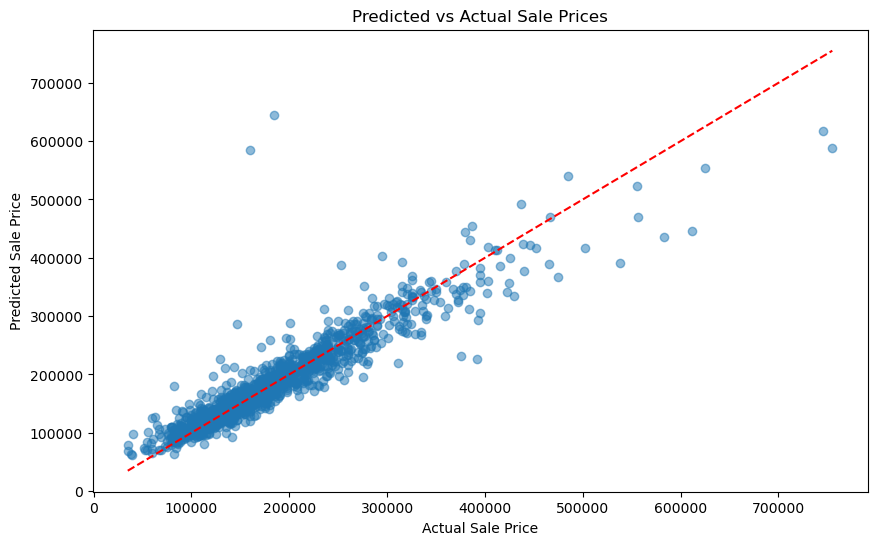

In [20]:
# Create ensemble predictions
ensemble_preds = (rf_preds + xgb_preds) / 2

# Create submission file
submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': ensemble_preds
})

submission.to_csv('submission.csv', index=False)


# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y, (rf_oof + xgb_oof) / 2, alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Predicted vs Actual Sale Prices')
plt.savefig('figures/prediction_visualization.png')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(y, kde=True)
plt.title('Distribution of Actual Sale Prices')
plt.xlabel('Sale Price')

plt.subplot(1, 2, 2)
sns.histplot(ensemble_preds, kde=True)
plt.title('Distribution of Predicted Sale Prices')
plt.xlabel('Sale Price')

plt.tight_layout()
plt.savefig('figures/price_distributions.png')
plt.close()